# Registration for calcium imaging data

# 0. Loading and preparing

load python libraries

In [1]:
from skimage.external.tifffile import imread, TiffWriter
import os # os stands for "operating system" and includes read/write routines etc. 
import numpy as np # by far the most used library for everyday computation
from scipy import stats # here we import a whole sub-library of stats functions
from scipy.ndimage import gaussian_filter # here we import a single function
from sklearn.decomposition import PCA # check out all the other dimensionality reduction methods in "decomposition"
from matplotlib import pyplot as plt # all of our plotting is done with plt
from scipy.stats import zscore
import time # to time things

### 0.1 load data

We are going to load 2000 frames of this tiff. To load the whole tiff leave out the "pages" argument.

In [61]:
# data is green channel 
# green = functional (GCaMP), red = anatomical (tdTomato)
# if you have a red channel, you can use that for alignment instead, but often you only have green

root = 'D:/DATA/GT1/'
IM = imread(os.path.join(root, 'gt1_chan0.tif'), pages = range(0,2000))

C:\Users\carse\Anaconda3\envs\suite2p\lib\site-packages\skimage\external\tifffile\tifffile.py:1640: UserWarning: can not reshape (2000, 650, 1112) to (4500, 650, 1112)
  warnings.warn(str(e))


### 0.2 inspect data

<IPython.core.display.Javascript object>


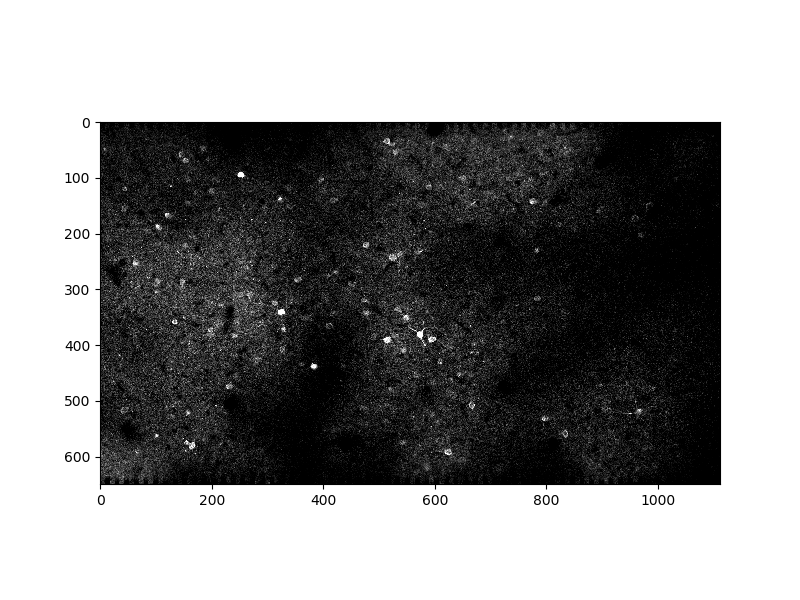

interactive(children=(IntSlider(value=0, description='iframe', max=1999), Output()), _dom_classes=('widget-int…

In [3]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
%matplotlib notebook

fig = plt.figure(figsize=(8,6))
fim = plt.imshow(IM[0], cmap='gray', vmin=500, vmax=5000)

def frame_show(iframe):
    fim.set_data(IM[iframe])
    plt.draw()
    plt.show()
    return fim

interact(frame_show, iframe=widgets.IntSlider(min=0, max=IM.shape[0]-1, step=1, value=0));

# 1. Iterative alignment to find a good reference image

### 1.1 take a subset of 250 frames and align them to their mean iteratively

We have functions to do this in suite2p. We will explain HOW we align in the next section.

In [4]:
from suite2p import run_s2p, register

ops = run_s2p.default_ops()
ops['Ly'], ops['Lx'] = IM.shape[1:]

# takes 250 frames and find the one with the most correlated pairs
# initializes reference using the average of that frame and its top 20 correlated frames
refImg = register.pick_init_init(IM[::8].copy())

# aligns all the frames to this reference image
# takes the mean of the aligned frames, then repeat (8 times)
refImg = register.refine_init(ops, IM[::8].copy(), refImg)

### 1.2 compare the result to the mean of those 250 frames

Iterative alignment improves registration target - it's more crisp

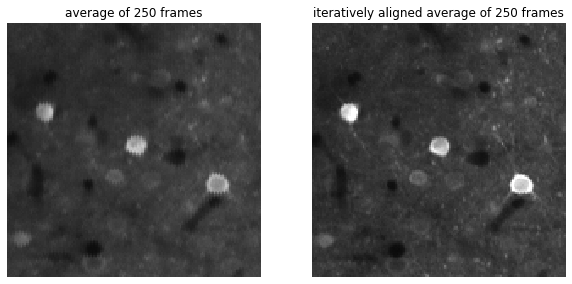

In [6]:
%matplotlib inline
fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(1,2,1)
ax.imshow(IM[::8].mean(axis=0)[150:300,400:550], cmap='gray', vmin=0, vmax=5000)
ax.set_title('average of 250 frames')
ax.axis('off')

ax = fig.add_subplot(1,2,2)
ax.imshow(refImg[150:300,400:550], cmap='gray', vmin=0, vmax=5000)
ax.set_title('iteratively aligned average of 250 frames')
ax.axis('off')

plt.show()

# 2. How to align frames to a given target

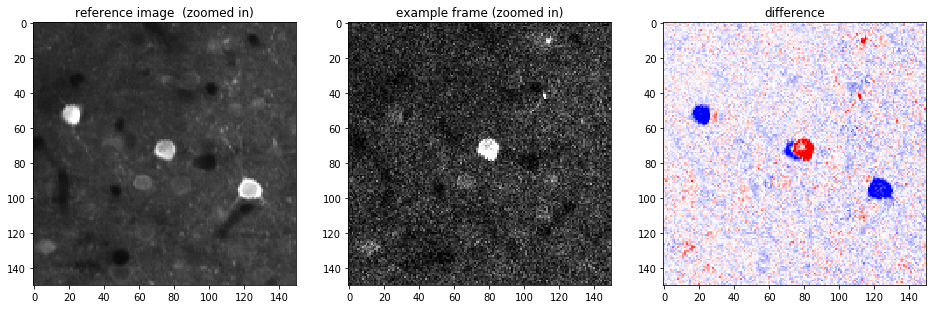

In [62]:
i = 1003
frame = IM[i].copy()

fig = plt.figure(figsize=(16,5))

ax = fig.add_subplot(1,3,1)
ax.imshow(refImg[150:300,400:550], cmap='gray', vmin=0, vmax=5000)
ax.set_title('reference image  (zoomed in)')

ax = fig.add_subplot(1,3,2)
ax.imshow(frame[150:300,400:550], cmap='gray', vmin=0, vmax=5000)
ax.set_title('example frame (zoomed in)')

ax = fig.add_subplot(1,3,3)
ax.imshow(frame[150:300,400:550] - refImg[150:300,400:550], cmap='bwr', vmin=-3000,vmax=3000)
ax.set_title('difference')

plt.show()

### 2.1 compute frame-to-reference correlation at all XY offsets

We will do this by looping over all offsets +/- 20 pixels and computing the correlation between the frame and the reference at each offset.

In [8]:
tic=time.time()
Ly,Lx = frame.shape
lycent = int(np.floor(Ly/2))+1
lxcent = int(np.floor(Lx/2))+1
ly = lycent - 21
lx = lxcent - 21
cc = np.zeros((39,39))
for ix,dx in enumerate(np.arange(-19,20,1,int)):
    for iy,dy in enumerate(np.arange(-19,20,1,int)):
        cc[iy,ix] = np.corrcoef(frame[lycent-ly+dy:lycent+ly+dy, lxcent-lx+dx:lxcent+lx+dx].flatten(), 
                          refImg[20:-20, 20:-20].flatten())[0,1]
        
print('Time elapsed: %2.2f seconds'%(time.time()-tic))        

Time elapsed: 22.04 seconds


### 2.2 find peaks in the cross-correlation map

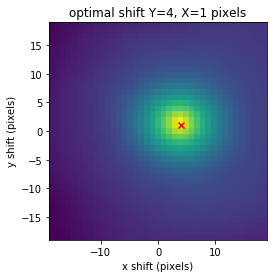

(4, -1)

In [9]:
# image of correlation and its maximum
def plot_and_max(cc):
    xb,yb = np.unravel_index(np.argmax(cc), cc.shape)
    xb,yb = xb-19,yb-19
    plt.imshow(cc, extent=[-19,19,-19,19])
    plt.scatter(yb,xb*-1,marker='x',color='r')
    plt.xlabel('x shift (pixels)')
    plt.ylabel('y shift (pixels)')
    plt.title('optimal shift Y=%d, X=%d pixels'%(yb,-1*xb))
    plt.show()
    return yb,xb

plot_and_max(cc)

### 2.3 fast cross-correlation with the Fourier transform

Cross-correlation is the same as the convolution of the frame with the reference.

**convolution theorem**: convolution in time domain equals point-wise multiplication in the frequency domain (and vice versa)

Time elapsed: 0.06 seconds


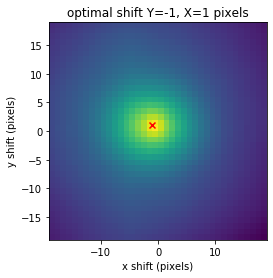

(-1, -1)

In [43]:
# take the fourier transform of the frame and the reference
tic = time.time()
frame_fft = np.fft.fft2(frame)
refImg_fft = np.fft.fft2(refImg)

cc = np.fft.fftshift(np.real(np.fft.ifft2(frame_fft * np.conj(refImg_fft))))
cc = cc[lycent-19:lycent+19,lxcent-19:lxcent+19]

print('Time elapsed: %2.2f seconds'%(time.time()-tic))    

plot_and_max(cc)

### 2.4 from cross-correlation to phase-correlation via spectral whitening

phase-correlation only compares the phases not the magnitudes of the fft at different frequencies. Equivalent to whitening the images first:

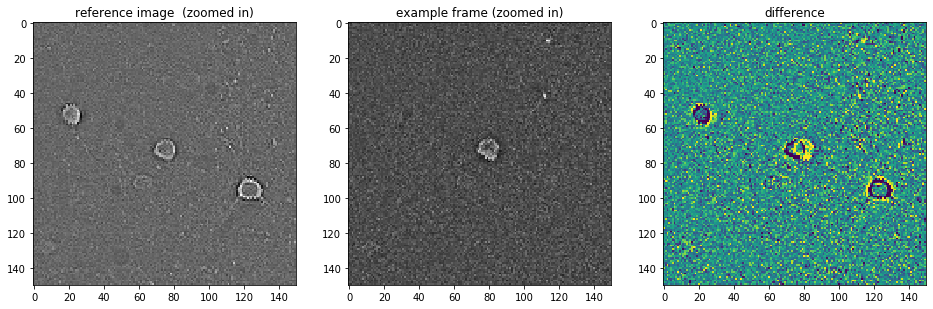

In [63]:
def whiten(img):
    img = np.fft.fft2(img)
    img /= np.abs(img) + 1e-20
    img = np.real(np.fft.ifft2(img))
    return img

frame_white = whiten(frame.copy())
refImg_white = whiten(refImg.copy())

fig = plt.figure(figsize=(16,5))

ax = fig.add_subplot(1,3,1)
ax.imshow(refImg_white[150:300,400:550], cmap='gray')
ax.set_title('reference image  (zoomed in)')

ax = fig.add_subplot(1,3,2)
ax.imshow(frame_white[150:300,400:550], cmap='gray')
ax.set_title('example frame (zoomed in)')

ax = fig.add_subplot(1,3,3)
ax.imshow(frame_white[150:300,400:550] - refImg_white[150:300,400:550], vmin=-.005,vmax=.005)
ax.set_title('difference')

plt.show()

Time elapsed: 0.08 seconds


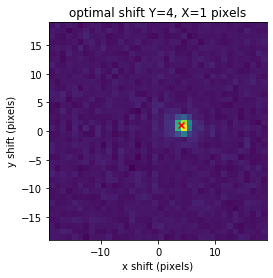

In [11]:
def phase_corr(frame, refImg):
    # take the fourier transform of the frame and the reference
    frame_fft = np.fft.fft2(frame)
    refImg_fft = np.fft.fft2(refImg)

    # normalize the fft by the absolute
    frame_fft /= np.abs(frame_fft) + 1e-20
    refImg_fft /= np.abs(refImg_fft) + 1e-20

    cc = np.fft.fftshift(np.real(np.fft.ifft2(frame_fft * np.conj(refImg_fft))))
    cc = cc[lycent-19:lycent+19,lxcent-19:lxcent+19]
    return cc

tic = time.time()
cc = phase_corr(frame, refImg)
print('Time elapsed: %2.2f seconds'%(time.time()-tic))    

yshift,xshift = plot_and_max(cc)

### 2.5 shift frame by integer pixel shifts

`np.roll` function shifts the image

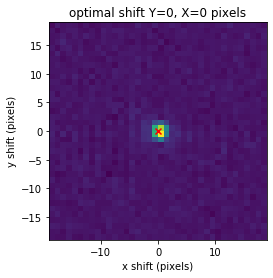

(0, 0)

In [12]:
# roll frame by xshift and yshift
freg = np.roll(frame.copy(), (-xshift, -yshift), axis=(0,1))

# check that there is no more shift necessary by taking phase-correlation
cc = phase_corr(freg, refImg)
plot_and_max(cc)

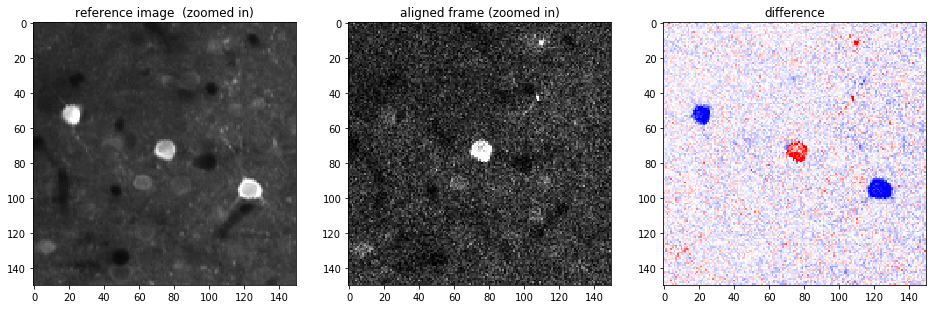

In [13]:
# look at aligned image

fig = plt.figure(figsize=(16,5))

ax = fig.add_subplot(1,3,1)
ax.imshow(refImg[150:300,400:550], cmap='gray', vmin=0, vmax=5000)
ax.set_title('reference image  (zoomed in)')

ax = fig.add_subplot(1,3,2)
ax.imshow(freg[150:300,400:550], cmap='gray', vmin=0, vmax=5000)
ax.set_title('aligned frame (zoomed in)')

ax = fig.add_subplot(1,3,3)
ax.imshow(freg[150:300,400:550] - refImg[150:300,400:550], cmap='bwr', vmin=-3000,vmax=3000)
ax.set_title('difference')

plt.show()

# 3. Non-rigid registration

We will divide the FOV into blocks and compute shifts of each block relative to the reference image:

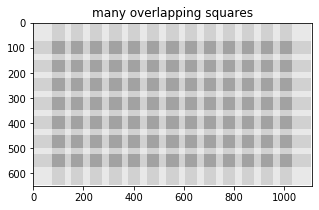

In [14]:
from suite2p import utils
ops = utils.make_blocks(ops)

imb = np.ones((Ly,Lx))
for iy,yb in enumerate(ops['yblock']):
    xb = ops['xblock'][iy]
    imb[yb[0]:yb[-1]-2, xb[0]:xb[-1]-2] -=1
    
fig = plt.figure(figsize=(5,5))
plt.imshow(imb,cmap='gray',vmin=-10)
plt.title('many overlapping squares')
plt.show()

### 3.1 compute shifts of each block

In [64]:
# compute the shift of each block
from suite2p import nonrigid

# this function divides reference image into blocks and takes fft
refAndMasks = nonrigid.prepare_masks(refImg, ops)

# this function computes shifts
# use the already rigidly aligned frame
ymax, xmax, cmax, ccsm = nonrigid.phasecorr(freg[np.newaxis,:,:], refAndMasks, ops)
ccsm = np.squeeze(ccsm)

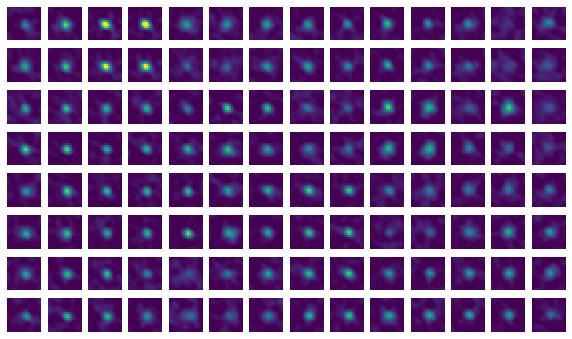

In [65]:
fig = plt.figure(figsize=(10,6))
for iy in range(ops['nblocks'][0]):
    for ix in range(ops['nblocks'][1]):
        ii = iy+ix*ops['nblocks'][0]
        ax = fig.add_subplot(ops['nblocks'][0], ops['nblocks'][1], ii+1)
        ax.imshow(ccsm[ii], extent=[-8,8,-8,8], vmin=0, vmax=.05)
        xm, ym = np.unravel_index(np.argmax(ccsm[ii]), ccsm[ii].shape)
        xm, ym = xm-8,ym-8
        ax.axis('off')
        

In [66]:
ops['nblocks']

[8, 14]

What are the shifts? Take the peaks of each of the correlation maps. We will represent these shifts as arrows.

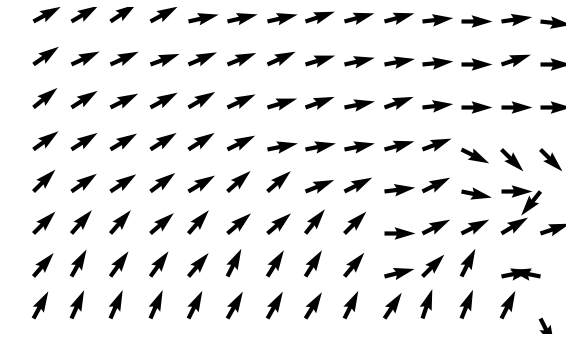

In [80]:
fig = plt.figure(figsize=(10,6))
for ix in range(ops['nblocks'][1]):
    for iy in range(ops['nblocks'][0]):
        ii = iy+ix*ops['nblocks'][0]
        plt.quiver(ops['xblock'][ii].mean(), ops['yblock'][ii].mean(), 
           xmax[0][ii], ymax[0][ii], edgecolors='k')
        
plt.axis('off')
plt.show()

We can make this into a flow field for each pixel in the image (not just each block), by interpolating these shifts.

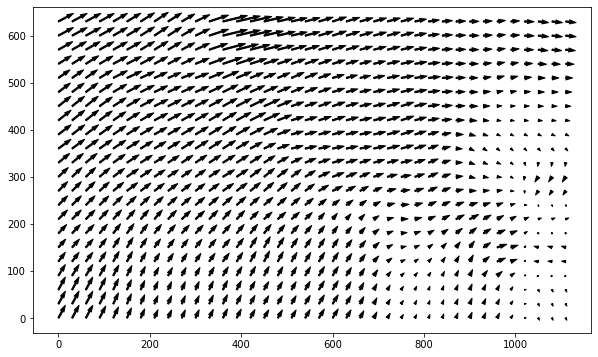

In [71]:
# interpolate shifts using bilinear interpolation
yup, xup = nonrigid.upsample_block_shifts(ops, ymax, xmax)
yup = np.squeeze(yup)
xup = np.squeeze(xup)

# show shifts
xgrid,ygrid = np.meshgrid(np.arange(0,Lx), np.arange(0,Ly))
ysp=30
fig=plt.figure(figsize=(10,6))
plt.quiver(xgrid[::ysp,::ysp].flatten(), ygrid[::ysp,::ysp].flatten(), 
           xup[::ysp,::ysp].flatten(), yup[::ysp,::ysp].flatten(), linewidths=1, edgecolors='k')
plt.show()


### 3.2 shift frames by non-rigid shifts

Now we have to warp the pixels by these shifts. We again use bilinear interpolation for this, but this time on the fluorescence values.

In [31]:
# we've rewritten bilinear map_coordinates to be faster (it's also available in skimage)
# we've written it as an inplace function (Y will change)
Y = np.zeros(freg.shape, np.float32)
nonrigid.map_coordinates(freg, (ygrid+yup).astype(np.float32), (xgrid+xup).astype(np.float32), Y)

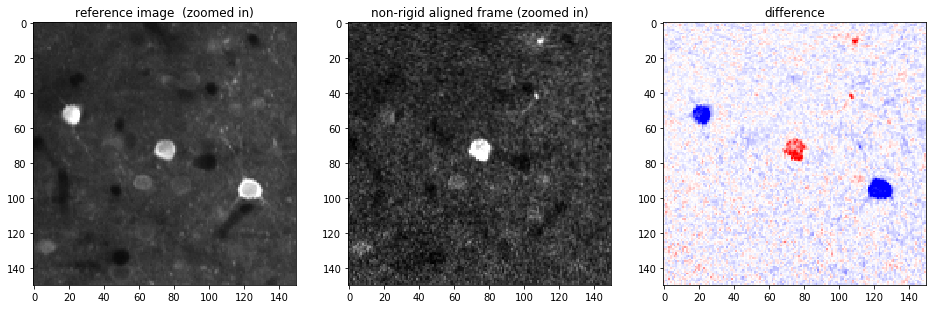

In [32]:
# look at aligned image
fig = plt.figure(figsize=(16,5))

ax = fig.add_subplot(1,3,1)
ax.imshow(refImg[150:300,400:550], cmap='gray', vmin=0, vmax=5000)
ax.set_title('reference image  (zoomed in)')

ax = fig.add_subplot(1,3,2)
ax.imshow(Y[150:300,400:550], cmap='gray', vmin=0, vmax=5000)
ax.set_title('non-rigid aligned frame (zoomed in)')

ax = fig.add_subplot(1,3,3)
ax.imshow(Y[150:300,400:550] - refImg[150:300,400:550], cmap='bwr', vmin=-3000,vmax=3000)
ax.set_title('difference')

plt.show()

# 4. How do we know it worked? 

### 4.1 use your eyes

We can see that the difference image doesn't have large shifts, it looks like changes in activity.

Some types of shifts:

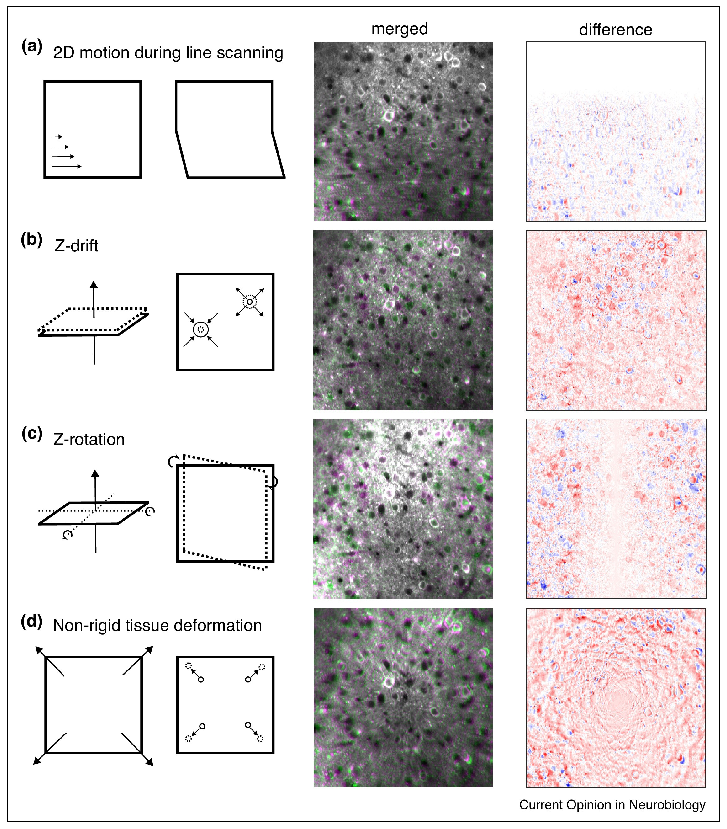

In [42]:
fig=plt.figure(figsize=(15,15))
plt.imshow(plt.imread('exshifts.jpg'))
plt.axis('off')
plt.show()

### 4.2 registration metrics: use PCA

We don't want to look at the difference between each frame and the reference image - that would be very tedious. Instead we can try to summarize the shifts by taking the principal components of the WHOLE movie. The principal components will vary across time, but the question is will they vary due to activity or due to movement of the FOV?

First we need to run all the frames:

In [35]:
refAndMasks = register.prepare_refAndMasks(refImg, ops)
imreg = np.zeros(IM.shape, np.int16)
for k in range(int(IM.shape[0]/100)):
    imreg[k*100:(k+1)*100],_,_,_,_ = register.register_and_shift(IM[k*100:(k+1)*100], refAndMasks, ops)
    if k%5==0:
        print(k)

0
5
10
15


Next we take the principal components of the frames and sort each frame based on its weight onto the PC. Then we take the average of the top 300 and bottom 300 frames in the sorting. 

In [38]:
from suite2p import regmetrics
nlowhigh = 300
nPC = 30
pclow, pchigh, sv, v = regmetrics.pclowhigh(IM[::3], nlowhigh, nPC)

We will illustrate them below, but in general I recommend looking at them in the GUI in regmetrics.

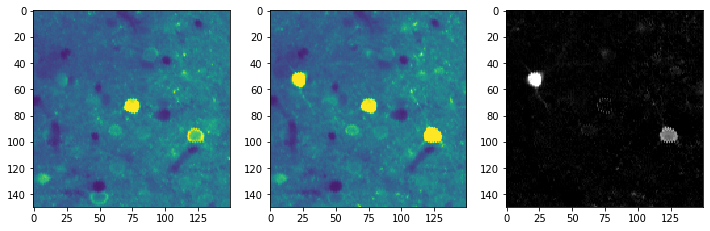

In [40]:
fig = plt.figure(figsize=(12,10))

ipc = 0
ax = fig.add_subplot(1,3,1)
ax.imshow(pclow[ipc][150:300, 400:550], vmin=0, vmax=3000)

ax = fig.add_subplot(1,3,2)
ax.imshow(pchigh[ipc][150:300, 400:550], vmin=0, vmax=3000)

ax = fig.add_subplot(1,3,3)
ax.imshow(pchigh[ipc][150:300, 400:550] - pclow[ipc][150:300, 400:550], cmap='gray', vmin=0, vmax=3000)
plt.show()

Let's compare these frames from the two extremes of the PC. Do these differ in activity or are they shifted from each other in some other way?

In [41]:
if 'block_size' not in ops:
    ops['block_size']   = [128, 128]
if 'maxregshiftNR' not in ops:
    ops['maxregshiftNR'] = 5

X    = regmetrics.pc_register(pclow, pchigh, ops['refImg'],
                   ops['smooth_sigma'], ops['block_size'], ops['maxregshift'], ops['maxregshiftNR'], ops['1Preg'])

ops['regPC'] = np.concatenate((pclow[np.newaxis, :,:,:], pchigh[np.newaxis, :,:,:]), axis=0)
ops['regDX'] = X
ops['tPC'] = v

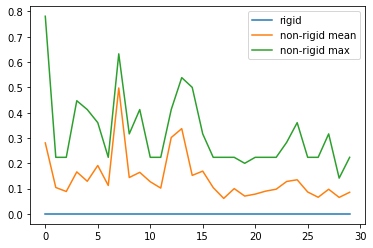

In [42]:
plt.plot(ops['regDX'][:,0], label='rigid')
plt.plot(ops['regDX'][:,1], label='non-rigid mean')
plt.plot(ops['regDX'][:,2], label='non-rigid max')
plt.legend()
plt.show()